In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def process_two_signals(signal_1_df, signal_2_df, threshold):
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="yourpassword",
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()

    # Validate inputs
    if signal_1_df.empty or signal_2_df.empty:
        raise ValueError("Input DataFrames must not be empty.")
    if not all(col in signal_1_df.columns for col in ['ts', 'values']):
        raise ValueError("signal_1_df must contain 'ts' and 'values' columns.")
    if not all(col in signal_2_df.columns for col in ['ts', 'values']):
        raise ValueError("signal_2_df must contain 'ts' and 'values' columns.")

    # Convert to lists
    signal_1_ts = signal_1_df['ts'].tolist()
    signal_1_values = signal_1_df['values'].tolist()
    signal_2_ts = signal_2_df['ts'].tolist()
    signal_2_values = signal_2_df['values'].tolist()

    try:
        cur.execute(
            """
            SELECT * FROM process_two_signals(%s::float[], %s::float[], %s::float[], %s::float[], %s);
            """,
            (signal_1_ts, signal_1_values, signal_2_ts, signal_2_values, threshold)
        )
        result = cur.fetchall()
        # Convert the result into a Pandas DataFrame
        if result:
            df = pd.DataFrame(result, columns=["ts", "summed_value"])
            return df
        else:
            return pd.DataFrame(columns=["ts", "summed_value"])
    finally:
        cur.close()
        conn.close()


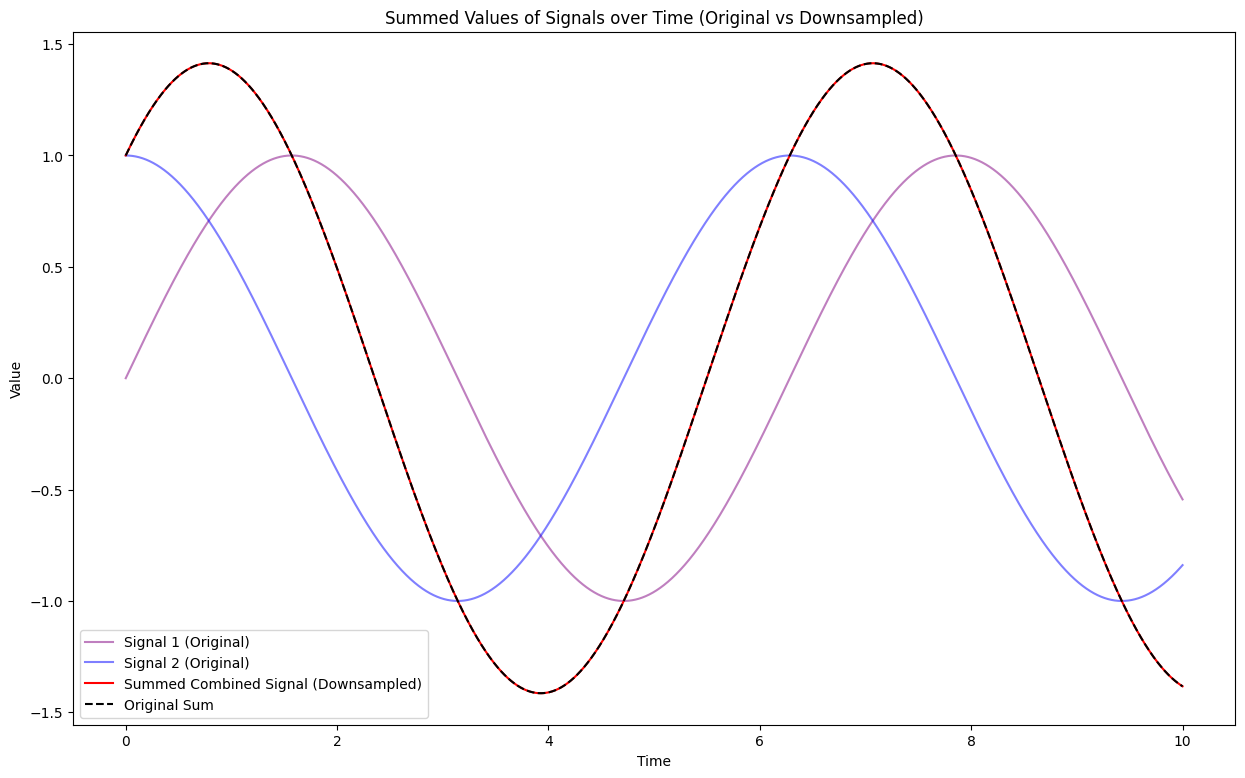

In [3]:
# Generate signals
np.random.seed(42)
number = 500000
time = np.linspace(0, 10, number)
signal_1 = np.sin(time)
signal_2 = np.cos(time)

# Create DataFrames for the signals
df_signal_1 = pd.DataFrame({
    "ts": time,
    "values": signal_1
})

df_signal_2 = pd.DataFrame({
    "ts": time,
    "values": signal_2
})

# Compute the original sum for comparison
original_sum = signal_1 + signal_2

# Process and merge the signals using the PostgreSQL function
threshold = 1000  # Downsample to 1000 points
merged_df = process_two_signals(df_signal_1, df_signal_2, threshold)

# Plot the original, summed, and merged signals
plt.figure(figsize=(15, 9))

# Plot original signals
plt.plot(df_signal_1['ts'], df_signal_1['values'], color='purple', label='Signal 1 (Original)', alpha=0.5)
plt.plot(df_signal_2['ts'], df_signal_2['values'], color='blue', label='Signal 2 (Original)', alpha=0.5)

# Plot merged signals
plt.plot(merged_df['ts'], merged_df['summed_value'], color='red', label='Summed Combined Signal (Downsampled)')

# Plot the original sum
plt.plot(time, original_sum, color='black', label='Original Sum', linestyle='--')

# Finalize the plot
plt.title('Summed Values of Signals over Time (Original vs Downsampled)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
